# An Analysis of Repeat Business in PBSB Artwork Data
In this notebook, I will explore the characteristics of repeat business based on data I've collected during the course of my painting career.

Data wrangling performed in the basic analysis is repeated here with minimal explanation.

## Import libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and logistic regression libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


## Import CSV file

In [6]:
# Define the URL of the dataset - in this case we are using a dataset that has been uploaded to OneDrive and shared
#file_path = "C:\\Users\\simon\\OneDrive\\Documents\\Artwork.csv"

# Load the dataset into a DataFrame
#df = pd.read_csv(file_path)

df = pd.read_csv("OneDrive/Documents/Artwork.csv", encoding='ISO-8859-1')

# Display the first few rows to ensure it loaded correctly
#print(df.head())

## Basic Data Wrangling and Transformation
Remove rows with missing values.

In [8]:
# Drop the rows with no order date and no sale type
df = df.dropna(subset=['OrderDate', 'SaleType'])

Clean up FinalRetailPrice column. Remove $ sign, thousands separator and trailing white space.

In [10]:
# Remove any trailing whitespace
df['FinalRetailPrice'] = df['FinalRetailPrice'].str.strip()

#Replace thousands separators
df['FinalRetailPrice'] = df['FinalRetailPrice'].str.replace(',', '')

# Replace '$' then convert to numeric
df['FinalRetailPrice'] = df['FinalRetailPrice'].str.replace('$', '').astype(float)


Normalize the price data for use throughout this analysis. Use the IQR to define the outlier bounds. In this case we only want to remove the very largest values and none of the small ones.

In [12]:
# Calc max and min painting prices
max_price = df['FinalRetailPrice'].max()
min_price = df['FinalRetailPrice'].min()

# Normalizereve nueusing max and min values
df['NormalizedPrice'] = (df['FinalRetailPrice'] - min_price) / (max_price - min_price)

# Recalculate quartiles and IQR
Q1 = df['NormalizedPrice'].quantile(0.25)
Q3 = df['NormalizedPrice'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds - these are broader than usual
lower_bound = Q1 - 20 * IQR
upper_bound = Q3 + 20 * IQR

# Remove outliers from dataframe
df = df[(df['NormalizedPrice'] <= upper_bound)]

Convert the OrderDate to datetime format

In [14]:
# Convert the OrderDate column to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

In [15]:
# Create a Year column
df['Year'] = df['OrderDate'].dt.year.astype(int)

Convert some required columns to numeric

In [17]:
# Convert columns to numeric
df['NumSubjects'].astype(float)

0      0.0
1      3.0
2      1.0
3      1.0
4      1.0
      ... 
576    0.0
577    0.0
578    0.0
579    0.0
580    0.0
Name: NumSubjects, Length: 578, dtype: float64

### Repeat Business Analysis for Commissioned Portraits
To start this analysis, let's Look at how long it takes to generate repeat business. We are only interested in Commission work.

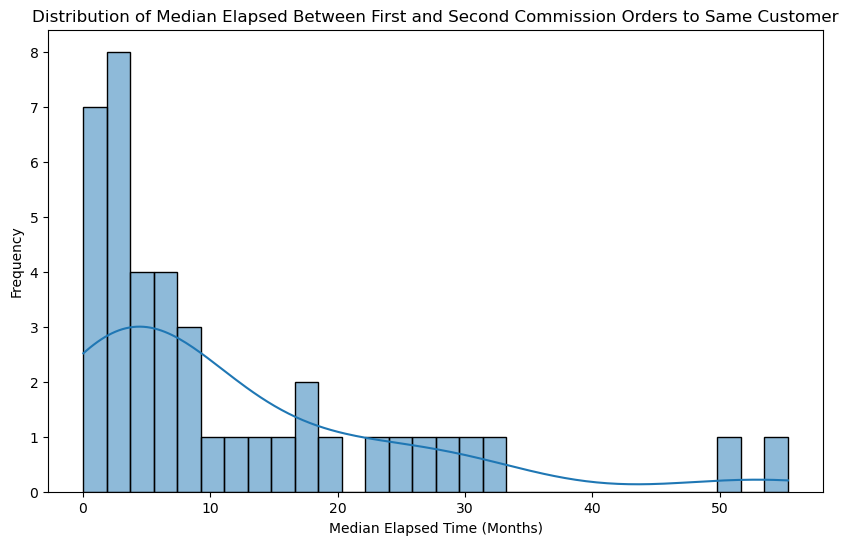

In [19]:
# Filter for Commissions only
df_filtered = df[df['ServiceType'] == 'Commission']

# Sort the dataframe by CustomerID and OrderDate
df_sorted = df_filtered.sort_values(by=['CustomerID', 'OrderDate'])

# Group by CustomerID and get the first and second transactions
first_second_transactions = df_sorted.groupby('CustomerID').nth([0, 1]).reset_index()

# Calculate the elapsed time in months between the first and second transactions
first_second_transactions['ElapsedMonths'] = (first_second_transactions.groupby('CustomerID')['OrderDate'].diff().dt.days / 30).fillna(0)

# Calculate the median elapsed time in months
median_elapsed_months = first_second_transactions.groupby('CustomerID')['ElapsedMonths'].median()

# Filter out values where the median elapsed time is zero
median_elapsed_months = median_elapsed_months[median_elapsed_months > 0]

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(median_elapsed_months, bins=30, kde=True)
plt.title('Distribution of Median Elapsed Between First and Second Commission Orders to Same Customer')
plt.xlabel('Median Elapsed Time (Months)')
plt.ylabel('Frequency')

# Save the plot as a PNG file
plt.savefig('repeat_commissions_distribution.png', format='png', dpi=300)

plt.show()

Relative value of repeat business vs single transaction sales: 0.62


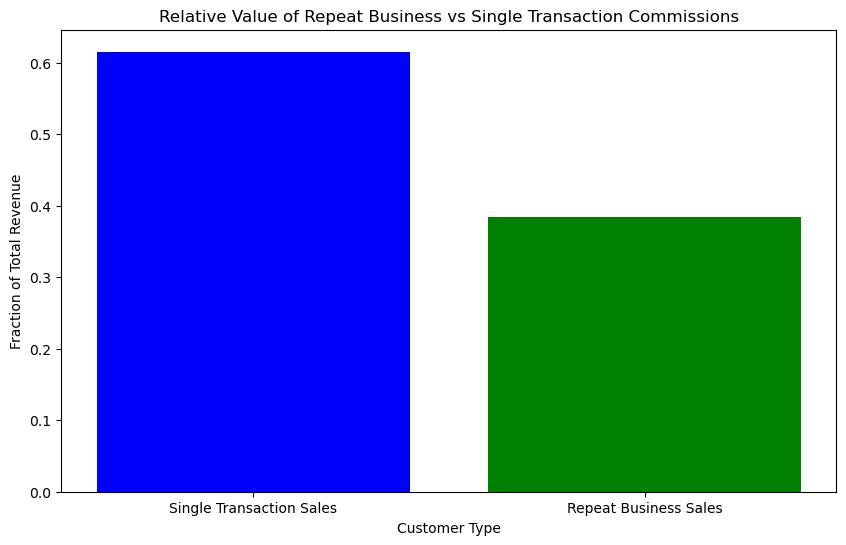

In [20]:
# Using same df_filtered as in previous cell

# Calculate the number of transactions per CustomerID
transaction_counts = df_filtered.groupby('CustomerID').size()

# Separate customers with only one transaction and those with repeat transactions
single_transaction_customers = transaction_counts[transaction_counts == 1].index
repeat_transaction_customers = transaction_counts[transaction_counts > 1].index

# Calculate the total sales for single transaction customers
single_transaction_sales = df[df['CustomerID'].isin(single_transaction_customers)]['NormalizedPrice'].astype(float).sum()

# Calculate the total sales for repeat transaction customers
repeat_transaction_sales = df[df['CustomerID'].isin(repeat_transaction_customers)]['NormalizedPrice'].astype(float).sum()

# Add both together and use the total to re-normalize the single and repeat sales
total_sales = single_transaction_sales + repeat_transaction_sales
single_transaction_sales = single_transaction_sales/total_sales
repeat_transaction_sales = repeat_transaction_sales/total_sales

# Calculate the relative value
relative_value = repeat_transaction_sales / single_transaction_sales

print(f"Relative value of repeat business vs single transaction sales: {relative_value:.2f}")

# Plot the relative value as a column chart
labels = ['Single Transaction Sales', 'Repeat Business Sales']
values = [single_transaction_sales, repeat_transaction_sales] 

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green'])
plt.title('Relative Value of Repeat Business vs Single Transaction Commissions')
plt.xlabel('Customer Type')
plt.ylabel('Fraction of Total Revenue')

# Save the plot as a PNG file
plt.savefig('repeat_commissions_split.png', format='png', dpi=300)

plt.show()

## Repeat Business Analysis for Retail Artwork
The same analysis repeated, but for retail artwork sales.

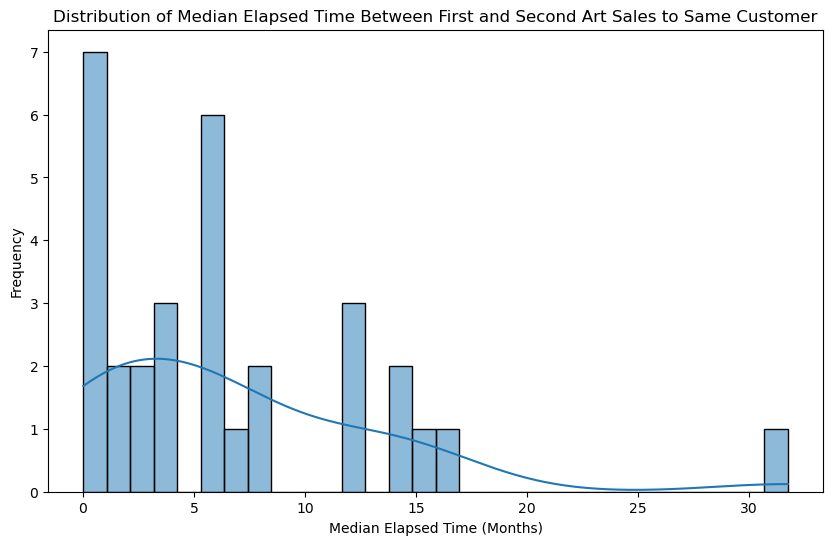

In [22]:
# Filter for Commissions only
df_filtered = df[df['ServiceType'] == 'Artwork sale']

# Sort the dataframe by CustomerID and OrderDate
df_sorted = df_filtered.sort_values(by=['CustomerID', 'OrderDate'])

# Group by CustomerID and get the first and second transactions
first_second_transactions = df_sorted.groupby('CustomerID').nth([0, 1]).reset_index()

# Calculate the elapsed time in months between the first and second transactions
first_second_transactions['ElapsedMonths'] = (first_second_transactions.groupby('CustomerID')['OrderDate'].diff().dt.days / 30).fillna(0)

# Calculate the median elapsed time in months
median_elapsed_months = first_second_transactions.groupby('CustomerID')['ElapsedMonths'].median()

# Filter out values where the median elapsed time is zero
median_elapsed_months = median_elapsed_months[median_elapsed_months > 0]

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(median_elapsed_months, bins=30, kde=True)
plt.title('Distribution of Median Elapsed Time Between First and Second Art Sales to Same Customer')
plt.xlabel('Median Elapsed Time (Months)')
plt.ylabel('Frequency')

# Save the plot as a PNG file
plt.savefig('repeat_artwork_distribution.png', format='png', dpi=300)

plt.show()

Relative value of repeat business vs single transaction sales: 0.97


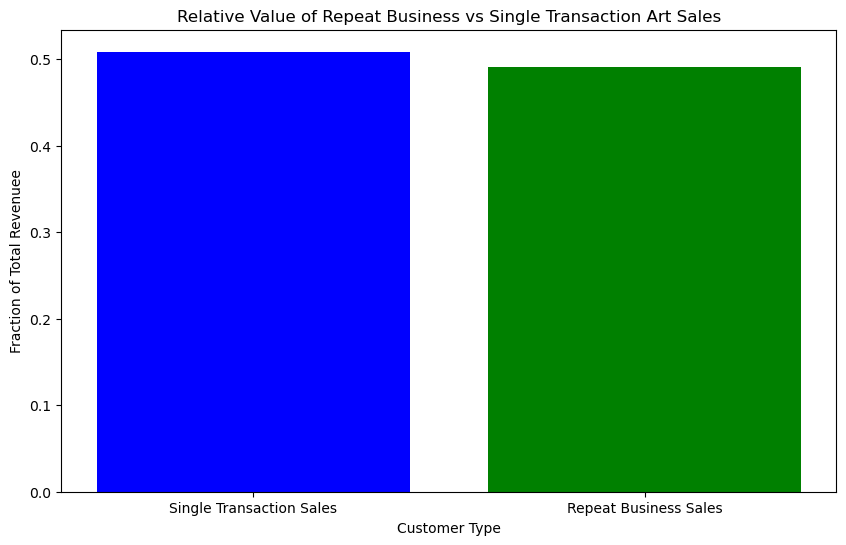

In [23]:
# Using same df_filtered as in previous cell

# Calculate the number of transactions per CustomerID
transaction_counts = df_filtered.groupby('CustomerID').size()

# Separate customers with only one transaction and those with repeat transactions
single_transaction_customers = transaction_counts[transaction_counts == 1].index
repeat_transaction_customers = transaction_counts[transaction_counts > 1].index

# Calculate the total sales for single transaction customers
single_transaction_sales = df[df['CustomerID'].isin(single_transaction_customers)]['NormalizedPrice'].astype(float).sum()

# Calculate the total sales for repeat transaction customers
repeat_transaction_sales = df[df['CustomerID'].isin(repeat_transaction_customers)]['NormalizedPrice'].astype(float).sum()

# Add both together and use the total to re-normalize the single and repeat sales
total_sales = single_transaction_sales + repeat_transaction_sales
single_transaction_sales = single_transaction_sales/total_sales
repeat_transaction_sales = repeat_transaction_sales/total_sales

# Calculate the relative value
relative_value = repeat_transaction_sales / single_transaction_sales
print(f"Relative value of repeat business vs single transaction sales: {relative_value:.2f}")

# Plot the relative value as a column chart
labels = ['Single Transaction Sales', 'Repeat Business Sales']
values = [single_transaction_sales, repeat_transaction_sales] 

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green'])
plt.title('Relative Value of Repeat Business vs Single Transaction Art Sales')
plt.xlabel('Customer Type')
plt.ylabel('Fraction of Total Revenuee')

# Save the plot as a PNG file
plt.savefig('repeat_artwork_split.png', format='png', dpi=300)

plt.show()